# Train  a new classifier for CoastSat

In this notebook the CoastSat classifier is trained using satellite images from new sites. This can improve the accuracy of the shoreline detection if the users are experiencing issues with the default classifier.

#### Initial settings

In [55]:
# load modules
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

# coastsat modules
sys.path.insert(0, os.pardir)
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_classify

# plotting params
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12

# filepaths 
filepath_images = os.path.join(os.pardir, 'data')
filepath_train = os.path.join(os.getcwd(), 'training_data')

# settings
settings ={'cloud_thresh':0.9, # percentage of cloudy pixels accepted on the image
           'cloud_mask_issue':False, # set to True if problems with the default cloud mask 
           'inputs':{'filepath':filepath_images}, # folder where the images are stored
           'labels':{'sand':1,'white-water':2,'water':3,'other land features':4}, # labels for the classifier
           'colors':{'sand':[1, 0.65, 0],'white-water':[1,0,1],'water':[0.1,0.1,0.7],'other land features':[0.8,0.8,0.1]},
           'flood_fill': True, # set to True to use the flood fill functionality
           'tolerance':0.02, # if flood_fill set to True, this is the pixel intensity tolerance 
           'filepath_train':filepath_train} # folder where the labelled images are stored

# read kml files for the training sites
filepath_sites = os.path.join(os.getcwd(), 'training_sites')
train_sites = os.listdir(filepath_sites)
print('Sites for training:\n%s\n'%train_sites)

### 1. Download images

For each site on which you want to train the classifier, save a .kml file with the region of interest (5 vertices clockwise, first and last points are the same, can be created from Google myMaps) in the folder *\training_sites*

In [54]:
# dowload images at the sites
filepath = os.path.join(os.pardir, 'data')
dates = ['2019-01-01', '2019-07-01']
sat_list = 'L8'
for site in train_sites:
   polygon = SDS_tools.polygon_from_kml(os.path.join(filepath_sites,site))
   sitename = site[:site.find('.')]  
   inputs = {'polygon':polygon, 'dates':dates, 'sat_list':sat_list,
             'sitename':sitename, 'filepath':filepath}
   print(sitename)
   metadata = SDS_download.retrieve_images(inputs)

### 2. Label images

Label the images into 4 classes: sand, white-water, water and other land features.

The labelled images are saved in the *filepath_train* and can be visualised afterwards for quality control. If yo make a mistake, don't worry, this can be fixed later by deleting the labelled image.

In [6]:
# label the images with an interactive annotator
%matplotlib qt
for site in train_sites:
    settings['inputs']['sitename'] = site[:site.find('.')] 
    # load metadata
    metadata = SDS_download.get_metadata(settings['inputs'])
    # label images
    SDS_classify.label_images(metadata,settings)

### 3. Train Classifier

A Multilayer Perceptron is trained with *scikit-learn*. To train the classifier, the training data needs to be loaded.

You can use the data that was labelled here and/or the original CoastSat training data.

In [49]:
# load labelled images
features = SDS_classify.load_labels(train_sites, settings)

Number of pixels per class in training data:
sand : 3287 pixels
white-water : 28 pixels
water : 6804 pixels
other land features : 16326 pixels


In [50]:
# you can also load the original CoastSat training data (and optionally merge it with your labelled data)
with open(os.path.join(settings['filepath_train'], 'CoastSat_original_training_set_L8.pkl'), 'rb') as f:
    features_original = pickle.load(f)
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 3287 pixels
white-water : 28 pixels
water : 6804 pixels
other land features : 16326 pixels


Run this section to combine the original training data with your labelled data:

In [51]:
# add the white-water data from the original training data
features['white-water'] = np.append(features['white-water'], features_original['white-water'], axis=0)
# or merge all the classes
# for key in features.keys():
#     features[key] = np.append(features[key], features_original[key], axis=0)
# features = features_original 
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 3287 pixels
white-water : 780 pixels
water : 6804 pixels
other land features : 16326 pixels


As the classes do not have the same number of pixels, it is good practice to subsample the very large classes (in this case 'water' and 'other land features'):

In [52]:
# subsample randomly the land and water classes
# as the most important class is 'sand', the number of samples should be close to the number of sand pixels
n_samples = 5000 
for key in ['water', 'other land features']:
    features[key] =  features[key][np.random.choice(features[key].shape[0], n_samples, replace=False),:]
# print classes again
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 3287 pixels
white-water : 780 pixels
water : 5000 pixels
other land features : 5000 pixels


When the labelled data is ready, format it into **X**, a matrix of features, and **y**, a vector of labels:

In [23]:
# format into X (features) and y (labels) 
classes = ['sand','white-water','water','other land features']
labels = [1,2,3,0]
X,y = SDS_classify.format_training_data(features, classes, labels)

Divide the dataset into train and test: train on 70% of the data and evaluate on the other 30%:

In [53]:
# divide in train and test and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='adam')
classifier.fit(X_train,y_train)
print('Accuracy: %0.4f' % classifier.score(X_test,y_test))

Accuracy: 0.9993


A more robust evaluation is 10-fold cross-validation (may take a few minutes to run):

In [19]:
# cross-validation
scores = cross_val_score(classifier, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.4f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9983 (+/- 0.0054)


Plot a confusion matrix:

Confusion matrix, without normalization


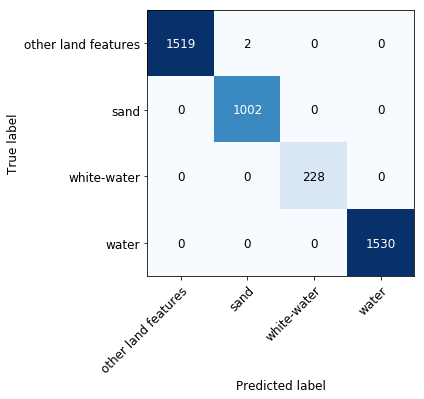

In [25]:
# plot confusion matrix
%matplotlib inline
y_pred = classifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

When satisfied with the accuracy and confusion matrix, train the model using ALL the training data and save it:

In [40]:
# train and save the final classifier
classifier = MLPClassifier(solver='adam')
classifier.fit(X,y)
joblib.dump(classifier, os.path.join(os.getcwd(), 'NN_4classes_L8_test.pkl'))

### 4. Evaluate the classifier

In [34]:
# load the classifier to be tested
%matplotlib qt
classifier = joblib.load(os.path.join(os.getcwd(), 'NN_4classes_L8_test.pkl'))
# visualise the classified images
for site in train_sites:
    settings['inputs']['sitename'] = site[:site.find('.')] 
    # load metadata
    metadata = SDS_download.get_metadata(settings['inputs'])
    # plot the classified images
    SDS_classify.evaluate_classifier(classifier,metadata,settings)